In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #visualization
import plotly.express as px
import seaborn as sns #visualization
from plotly.offline import init_notebook_mode, iplot, plot

Import Data

In [68]:
df = pd.read_csv('big_dataset.csv')
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


## **Preprocessing data**

The data set doesn't have any null values.
The original dataset had some duplicate entries that were removed when creating the new dataset.

Also we can convert the songs duration to seconds for better readibilty.

In [69]:
no_rows = df.shape[0]
df = df.drop_duplicates() # keep first duplicate row
df["duration_s"] = df.duration_ms.apply(lambda x : round(x/1000)) # add duration in seconds
df.drop("duration_ms", axis=1, inplace=True) #remove duration in ms
print("Dropped ", (no_rows-df.shape[0]), " duplicate rows" )
print("Dataset has", no_rows, "unique rows")


Dropped  0  duplicate rows
Dataset has 16730 unique rows


In [70]:

#Top Hits by Year
songs_per_years = df['year'].value_counts().sort_index()

iplot(px.bar(songs_per_years, 
       title='Songs per year',
       labels=dict(index='year',value='number of songs'),
       color_discrete_sequence=['#0055FF']
      ).update_xaxes(type='category'))


Since the years 1998, 1999 and 2020 have few examples, we will be removing songs from those years.
Also, we considered that the song **title** won't have any correlation with its popularity, so that column will be removed.



In [71]:
df = df[(df.year >= 2000) & (df.year <= 2022)]
df = df.drop(['song'], axis = 1) #removing song title column
#df.head()


In [72]:
songs_per_years = df['year'].value_counts().sort_index()

iplot(px.bar(songs_per_years,
       title='Songs per year',
       labels=dict(index='year',value='number of songs'),
       color_discrete_sequence=['#0055FF']
      ).update_xaxes(type='category'))

## Popularity classification
First let's analise the popularity distribution, and try to indentify existing outliers 

array([[<AxesSubplot:title={'center':'popularity'}>]], dtype=object)

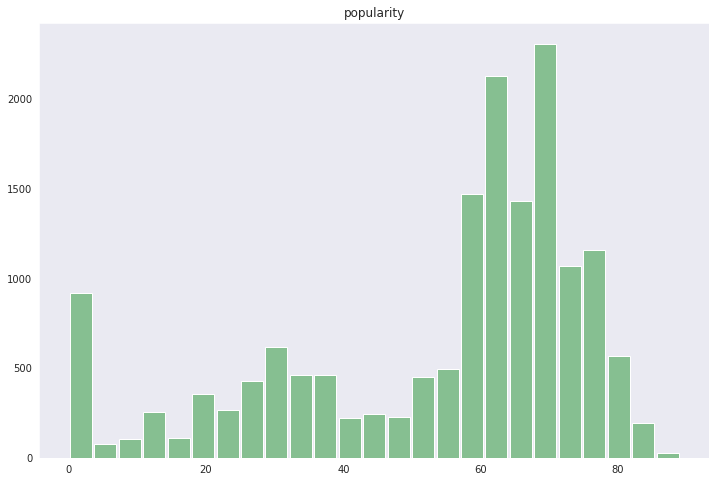

In [73]:
df.hist(column=('popularity'),bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)


In [74]:
df = df[(df.popularity > 5)]

array([[<AxesSubplot:title={'center':'popularity'}>]], dtype=object)

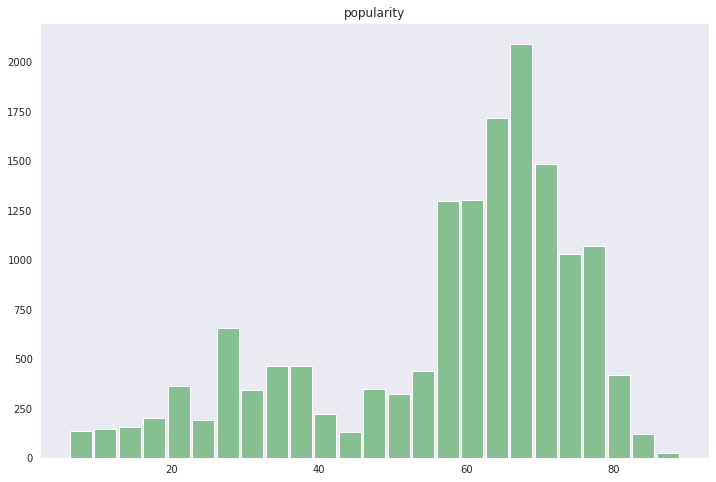

In [75]:
df.hist(column=('popularity'),bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

### Discretization 
- 11-62 not popular
- 62-72 semi-popular
- 72-89 popular

Bins:  [ 6. 57. 68. 89.]


<AxesSubplot:>

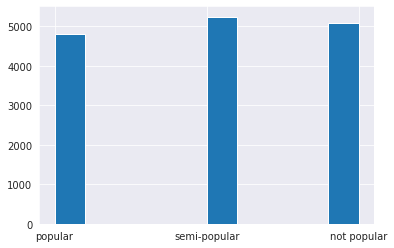

In [76]:
pop, bins = pd.qcut(df.popularity, 3, labels=["not popular", "semi-popular", "popular"], retbins = True)

print("Bins: ", bins)
pop.hist()

Adding the new class, **popularity_class**, based on popularity values

In [77]:
conditions = [
    (df['popularity'] <= 62),
    (df['popularity'] > 62) & (df['popularity'] <= 72),
    (df['popularity'] > 72)
    ]

labels = ["not popular", "semi-popular", "popular"]

#creating a new column
df['popularity_class'] = np.select(conditions, labels)


In [78]:
df.head()

,artist,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,duration_s,popularity_class
0,Britney Spears,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop,211,popular
3,Bon Jovi,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal",224,popular
4,*NSYNC,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop,201,semi-popular
6,Eminem,True,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.0302,0.000000,0.0454,0.760,104.504,hip hop,284,popular
7,Robbie Williams,False,2000,68,0.708,0.772,7,-4.264,1,0.0322,0.0267,0.000000,0.4670,0.861,103.035,"pop, rock",259,semi-popular



#### Pairplot
In order to better look for data errors, and to view correlation between the different columns.

In [ ]:
df['popularity_class'].unique()
num_var= ['year', 'danceability', 'energy', 'key','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']

sns.pairplot(df, hue = 'popularity_class', vars= num_var)

## Exploratory analysis

- How is the data distributed?
- Is there correlation between the columns and why do they exist?

We will use a heatmap to look for possible correlations.

In [ ]:
# Correlation between features
corr = df.corr()
#Heatmap
sns.heatmap(corr, cmap="vlag")


Observing the map, positive correlations are visible between:
- Loudness and Energy - the louder the song, the more energetic it is
- Valence e Danceability - the more positive the song, the more daceable it

Negative correlations:
- Energy and Acousticness - acoustic songs have less energy
- Year and Duration - songs tend to become shorter the more recent they are

## Classification

Since some of the columns have string data, it's necessary to encode it

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#all colums except popularity and popularity_class
le = preprocessing.LabelEncoder()
le.fit(df.artist)
encoded = df
encoded['artist'] = le.transform(df.artist)

le = preprocessing.LabelEncoder()
le.fit(df.genre)
encoded = df
encoded['genre'] = le.transform(df.genre)

cols = (encoded.columns.values.tolist())
cols.remove('popularity')
cols.remove('popularity_class')

#all inputs
inputs =df[cols].values

#all popularity_class labels
all_labels = df['popularity_class'].values

print("Encoded data:")
df.head()

The data is ready to be divided into training and testing sets.

In [ ]:
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(inputs, all_labels, test_size=0.20, random_state=1)

## Decision Tree
A grid search with cross validation is performed to find best parameters

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time

dt_classifier = DecisionTreeClassifier()

parameter_grid = {
                'criterion': ['gini'],
                'splitter': ['best','random'],
                'random_state': [None,1],
                }

cross_validation = StratifiedKFold(n_splits=3)

grid_search = GridSearchCV(dt_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

# start_time = time.time()
# grid_search.fit(inputs, all_labels)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# print("Time to train: %s seconds" % (time.time() - start_time))

In [ ]:
# Create the classifier
dt_classifier = DecisionTreeClassifier(criterion='gini',random_state=None, splitter='random')

# Train the classifier on the training set
dt_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
dt_classifier.score(testing_inputs, testing_classes)

## LinearSVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linearSVC_classifier = make_pipeline(StandardScaler(),
                     LinearSVC(random_state=0, tol=1e-5, max_iter=10e5))

linearSVC_classifier.fit(training_inputs, training_classes)
linearSVC_classifier.score(testing_inputs,testing_classes)

## K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time


knn_classifier = KNeighborsClassifier()

parameter_grid = {
                'n_neighbors': [x for x in range(5,40,5)],
                'weights': ['uniform','distance'],
                'algorithm': ['auto','ball_tree','kd_tree','brute'],
                'leaf_size': [x for x in range(20,40,5)],
                'p': [1,2],
                'n_jobs': [-1],
                }

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(knn_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

# start_time = time.time()
# grid_search.fit(inputs, all_labels)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# print("Time to train: %s seconds" % (time.time() - start_time))

In [ ]:
knn_classifier = KNeighborsClassifier(algorithm='ball_tree', leaf_size=20,n_jobs=-1,n_neighbors=10,p=1,weights='distance')
knn_classifier.fit(training_inputs,training_classes)
knn_classifier.score(testing_inputs,testing_classes)

## SVC

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
SVC_classifier = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVC_classifier.fit(training_inputs, training_classes)
SVC_classifier.score(training_inputs,training_classes)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(training_inputs,training_classes)
random_forest_classifier.score(testing_inputs,testing_classes)

## Voting Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

random_forest_classifier = RandomForestClassifier()
SVC_classifier = make_pipeline(StandardScaler(), SVC(gamma='auto'))
decision_tree_classifier = DecisionTreeClassifier(criterion='gini',random_state=None, splitter='random')

voting_classifier = VotingClassifier(estimators=[
         ('rf_classifier',random_forest_classifier),('svc', SVC_classifier),('dtc', decision_tree_classifier)], voting='hard')
voting_classifier.fit(training_inputs, training_classes)
voting_classifier.score(testing_inputs,testing_classes)

## Neural Networks


In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(inputs)
scaled_inputs = scaler.transform(inputs)
scaled_training_inputs = scaler.transform(training_inputs)
scaled_testing_inputs = scaler.transform(testing_inputs)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time


nt_classifier = MLPClassifier()

parameter_grid = {
                'hidden_layer_sizes':   ([tuple([100 for y in range(0,x)]) for x in range(1,6)]),
                'activation': ['identity','logistic','relu','tanh'],
                'solver': ['lbfgs'],
                'random_state': [None],
                'alpha': [1e-5],
                'learning_rate': ['constant','invscaling','adaptive'],
                'max_iter': [10e50],
                'early_stopping': [True]
                }

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(nt_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

# start_time = time.time()
# grid_search.fit(scaled_inputs, all_labels)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# print("Time to train: %s seconds" % (time.time() - start_time))

In [ ]:
nt_classifier = MLPClassifier(activation='relu', alpha=1e-05, early_stopping=True, hidden_layer_sizes=(16,),learning_rate='constant',max_iter=10e100,random_state=None,solver='lbfgs')
nt_classifier.fit(scaled_training_inputs,training_classes)
nt_classifier.score(scaled_testing_inputs,testing_classes)

## Neural Networks with Tensorflow

In [ ]:
import tensorflow as tf
from sklearn import preprocessing
import time

#all colums except popularity and popularity_class
le = preprocessing.LabelEncoder()
le.fit(all_labels)
encoded_all_labels = le.transform(all_labels)
le.fit(testing_classes)
encoded_testing_classes = le.transform(testing_classes)

(training_inputs2,
 validating_inputs,
 training_classes2,
 validating_classes) = train_test_split(scaled_inputs, encoded_all_labels, test_size=0.25, random_state=1)

tf.random.set_seed(42)
activation = "elu"
neurons = 128
initializer = 'lecun_uniform'

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16,input_shape=(16,)),
    tf.keras.layers.Dropout(0.1, seed = 5),
    tf.keras.layers.Dense(neurons,kernel_initializer=initializer,activation=activation),
    tf.keras.layers.Dense(neurons,kernel_initializer=initializer,activation=activation),
    tf.keras.layers.Dropout(0.1, seed = 7),
    tf.keras.layers.Dense(neurons,kernel_initializer=initializer,activation=activation),
    tf.keras.layers.Dense(neurons,kernel_initializer=initializer,activation=activation),
    tf.keras.layers.Dropout(0.1, seed = 3),
    tf.keras.layers.Dense(neurons,kernel_initializer=initializer,activation=activation),
    tf.keras.layers.Dense(neurons,kernel_initializer=initializer,activation=activation),
    tf.keras.layers.Dropout(0.1, seed = 9),
    tf.keras.layers.Dense(3, activation='softmax'),
    #tf.keras.layers.Dense(3, kernel_initializer='he_uniform', activation='sigmoid')
])


opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(optimizer=opt, #SGD
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

start_time = time.time()
model.fit(training_inputs2,
          training_classes2,
          batch_size=40,
          epochs=100,
         validation_data=(validating_inputs,validating_classes))

test_loss, test_acc = model.evaluate(scaled_testing_inputs,
                                    encoded_testing_classes, verbose=2)

print('\nTest accuracy:', test_acc)
print("Time to train: %s seconds" % (time.time() - start_time))
#Best: 0.332851 using {'batch_size': 40, 'epochs': 100}
#Best: 0.327004 using {'optimizer': 'SGD'}
#Best: 0.331731 using {'learn_rate': 0.01, 'momentum': 0.8}
#Best: 0.330343 using {'init_mode': 'lecun_uniform'}
#Best: 0.344265 using {'activation': 'linear'}

## Tuning Batch Size and Number of Epochs

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=inputs.shape[1], activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

numpy.random.seed(7)

model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# grid_result = grid.fit(scaled_inputs, all_labels)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

## Tuning the Training Optimization Algorithm

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=inputs.shape[1], activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(scaled_inputs, all_labels)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# Tuning Learning Rate and Momentum

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=inputs.shape[1], activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(scaled_inputs, all_labels)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# Tuning Network Weight Initialization

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(init_mode='uniform'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=inputs.shape[1], kernel_initializer=init_mode, activation='relu'))
	model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(scaled_inputs, all_labels)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# Tuning the Neuron Activation Function

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=inputs.shape[1], kernel_initializer='uniform', activation=activation))
	model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(scaled_inputs, all_labels)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# Tuning Dropout Regularization

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, weight_constraint=0):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=inputs.shape[1], kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(weight_constraint)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(scaled_inputs, all_labels)
# summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# Tuning the Number of Neurons in the Hidden Layer

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(neurons=1):
	# create model
	model = Sequential()
	model.add(Dense(neurons, input_dim=inputs.shape[1], kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(4)))
	model.add(Dropout(0.2))
	model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(scaled_inputs, all_labels)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))